# Section 1: Loading & Exploring Data

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Loading the dataset
data_path = "/Users/sridharmalladi/Desktop/Projects/ai_inventory_optimization/data/raw/retail_dataset.csv"  
df = pd.read_csv(data_path)

#Basic structure
print("Shape:", df.shape)
df.info()
df.head(3)


Shape: (73100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer


# --------------------------------------------------------------------

# Section 2: Exploratory Data Analysis (EDA)

In [42]:
#Converting date + Checking Basic Info
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

In [43]:
#null values
df.isnull().sum().sort_values(ascending=False)

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

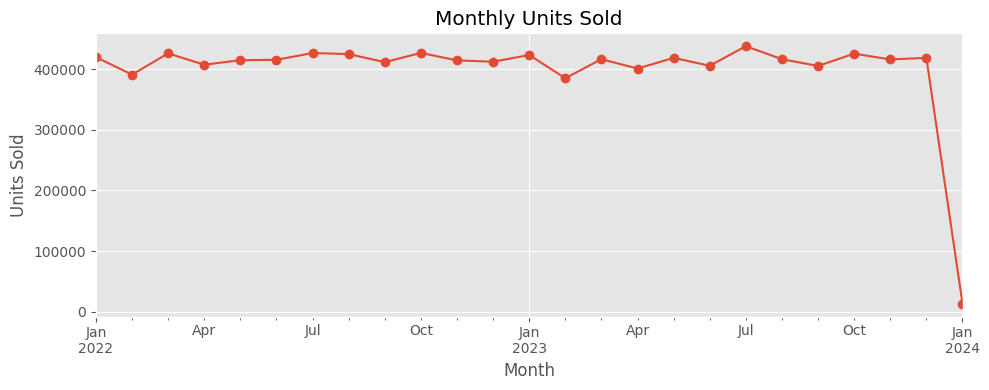

In [44]:
#Demand Over Time (Monthly)
import matplotlib.pyplot as plt
import seaborn as sns

df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Units Sold'].sum()

plt.figure(figsize=(10, 4))
monthly_sales.plot(marker='o')
plt.title("Monthly Units Sold")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()


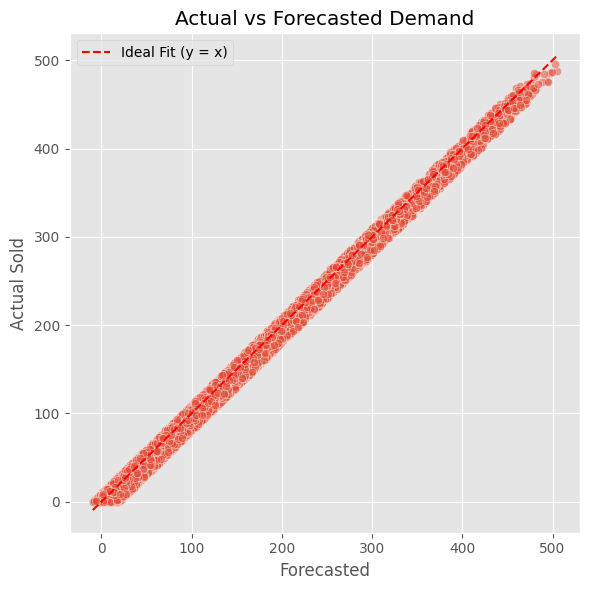

In [45]:
#Actual vs Forecaeted Demand
sample = df[['Units Sold', 'Demand Forecast']].dropna().sample(10000)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=sample, x='Demand Forecast', y='Units Sold', alpha=0.5)
plt.plot([sample['Demand Forecast'].min(), sample['Demand Forecast'].max()],
         [sample['Demand Forecast'].min(), sample['Demand Forecast'].max()],
         'r--', label='Ideal Fit (y = x)')
plt.title("Actual vs Forecasted Demand")
plt.xlabel("Forecasted")
plt.ylabel("Actual Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


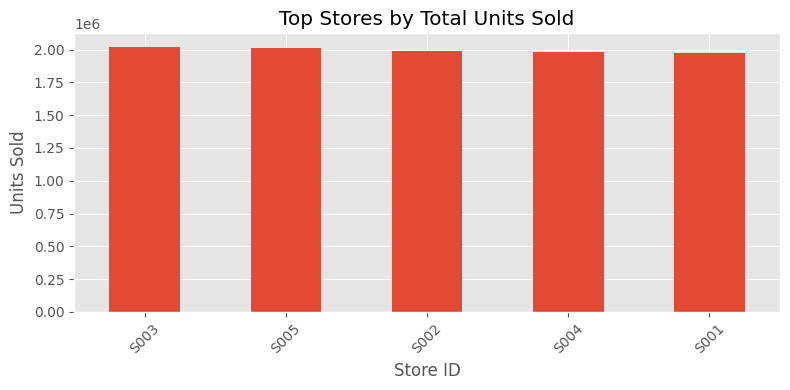

In [46]:
# Store-level Variation in Demand
top_stores = df.groupby('Store ID')['Units Sold'].sum().nlargest(10)

plt.figure(figsize=(8, 4))
top_stores.plot(kind='bar')
plt.title("Top Stores by Total Units Sold")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



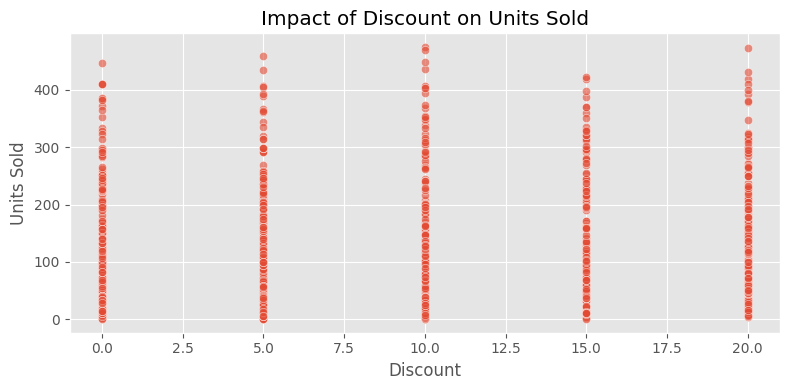

In [47]:
# Effect of Discount on Sales
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df.sample(1000), x='Discount', y='Units Sold', alpha=0.6)
plt.title("Impact of Discount on Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()



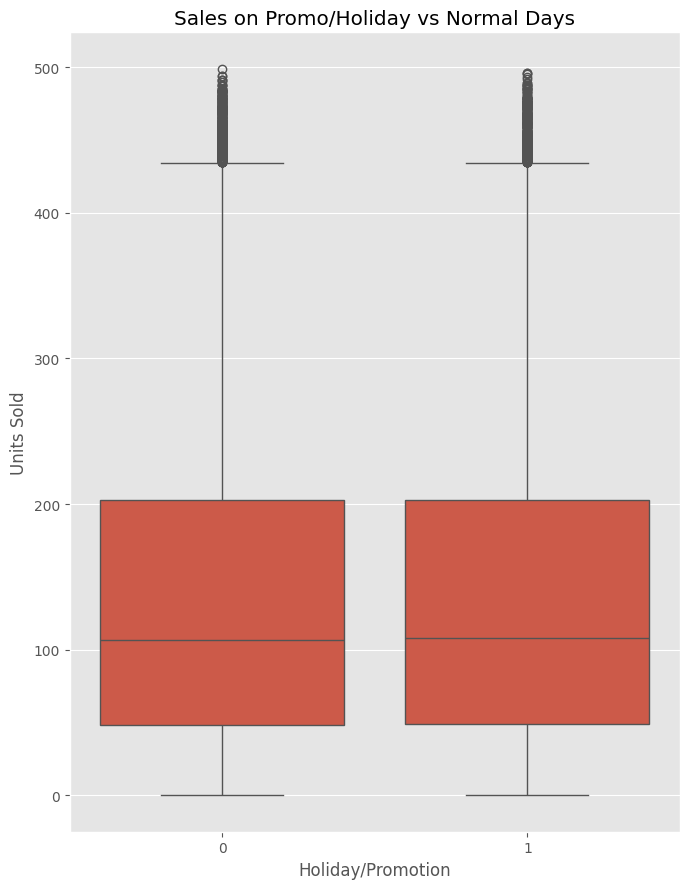

In [48]:
#Promotion and Holiday Impact
plt.figure(figsize=(7, 9))
sns.boxplot(data=df, x='Holiday/Promotion', y='Units Sold')
plt.title("Sales on Promo/Holiday vs Normal Days")
plt.tight_layout()
plt.show()



# --------------------------------------------------------------------

# Section 3: Feature Engineering + Demand Forecasting (ML)

In [49]:
#Basic date-based features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

#Encode holiday/promotion
df['IsPromo'] = df['Holiday/Promotion'].astype('category').cat.codes

#Rolling average demand (by Product ID)
df = df.sort_values(by=['Product ID', 'Date'])
df['RollingDemand7'] = df.groupby('Product ID')['Units Sold'].transform(lambda x: x.rolling(7, min_periods=1).mean())

#Drop rows with NA in new features 
df.dropna(subset=['RollingDemand7'], inplace=True)


In [50]:
from sklearn.model_selection import train_test_split

#Feature list 
features = ['DayOfWeek', 'IsWeekend', 'IsPromo', 'RollingDemand7', 'Discount']
target = 'Units Sold'

X = df[features]
y = df[target]

#Simple train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## 1. Using the Random Forest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 114.07
MAE: 89.84


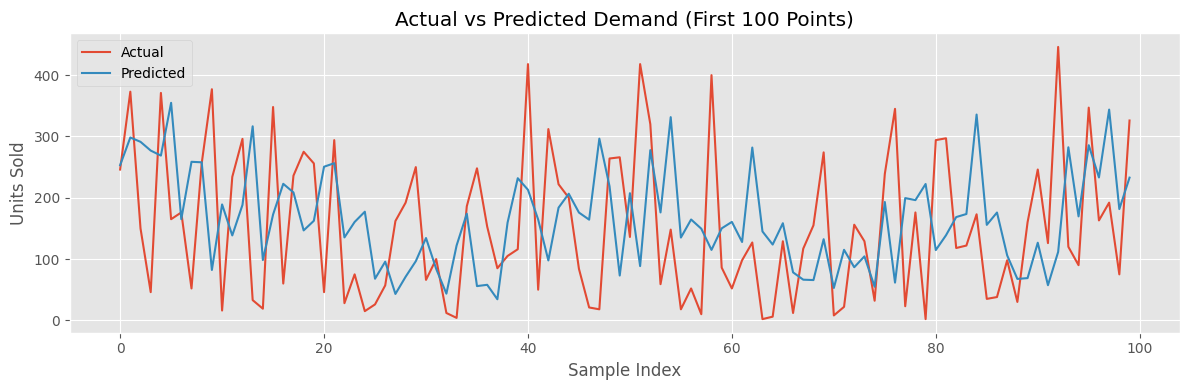

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title("Actual vs Predicted Demand (First 100 Points)")
plt.xlabel("Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Trying the XGBoost

In [54]:
# Feature: Lag (yesterday's sales)
df['Lag_1'] = df.groupby('Product ID')['Units Sold'].shift(1)

# Feature: 14-day rolling average
df['RollingDemand14'] = df.groupby('Product ID')['Units Sold'].transform(lambda x: x.rolling(14, min_periods=1).mean())

# Feature: Inventory level
df['Inventory Level'] = df['Inventory Level'].fillna(method='ffill')  # if missing
df['Inventory_Level'] = df['Inventory Level']  # rename for clarity

# Feature: Price per unit (optional)
df['Price'] = df['Price'].fillna(df['Price'].mean())

df.dropna(subset=['Lag_1', 'RollingDemand14'], inplace=True)


/var/folders/n4/d6h4j3h95x333c3mmcxh697w0000gn/T/ipykernel_53045/56266479.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Inventory Level'] = df['Inventory Level'].fillna(method='ffill')  # if missing


In [55]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [56]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# New features
features = ['DayOfWeek', 'IsWeekend', 'IsPromo', 'RollingDemand7', 'RollingDemand14',
            'Lag_1', 'Discount', 'Inventory_Level']

X = df[features]
y = df['Units Sold']

# Time-based split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)

print(f"[XGBoost] RMSE: {rmse:.2f}")
print(f"[XGBoost] MAE: {mae:.2f}")


[XGBoost] RMSE: 80.22
[XGBoost] MAE: 61.99


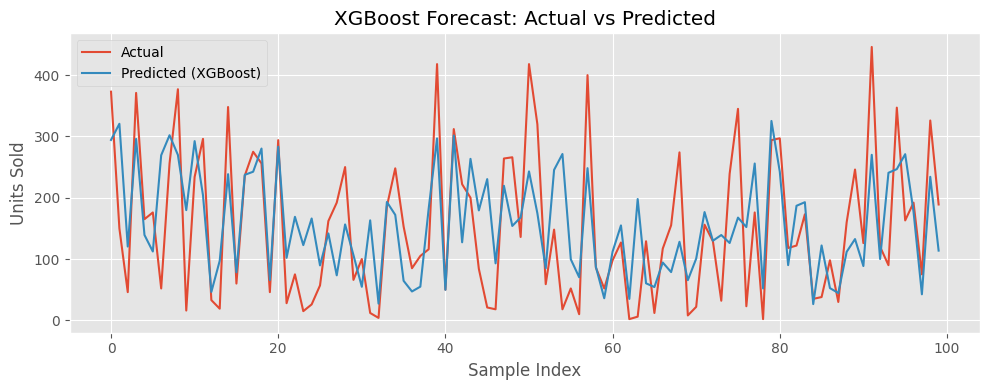

In [57]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred_xgb[:100], label='Predicted (XGBoost)')
plt.title("XGBoost Forecast: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Learnings:

### 1. Rolling averages, lag features, and promo/inventory info help boost prediction accuracy.

### 2. XGBoost outperforms Random Forest — lower error and better pattern capture.

### 3. Forecasting variability is still high (especially with spikes), but manageable for optimization.

### ✅  Final Decision: Choosing XGBoost as forecasting model. It’s more accurate and robust, especially useful for cost-saving decisions in inventory optimization and suitable in this specific scenario 

In [58]:
import pickle
import os

# Ensure the models folder exists
os.makedirs("models", exist_ok=True)

# Save the XGBoost model
with open("models/xgb_model.pkl", "wb") as f:
    pickle.dump(model_xgb, f)

print("✅ Model saved to models/xgb_model.pkl")


✅ Model saved to models/xgb_model.pkl


# --------------------------------------------------------------------

# Section 4: Inventory Optimization

## 1. Starting with one store


In [59]:
# Pick a store to work with
store_id = df['Store ID'].unique()[0]  # Example: Store 101
df_store = df[df['Store ID'] == store_id].copy()

# Filter for latest date
latest_date = df_store['Date'].max()
df_latest = df_store[df_store['Date'] == latest_date].copy()

# Define model features
features = ['DayOfWeek', 'IsWeekend', 'IsPromo', 'RollingDemand7', 'RollingDemand14',
            'Lag_1', 'Discount', 'Inventory_Level']

# Prepare input and predict
X_latest = df_latest[features]
df_latest.loc[:, 'Predicted Demand'] = model_xgb.predict(X_latest)

# Select top 10 products by predicted demand
df_optimize = df_latest[['Product ID', 'Predicted Demand']].sort_values(
    by='Predicted Demand', ascending=False).head(10).reset_index(drop=True)


In [60]:
df_latest.loc[:, 'Predicted Demand'] = model_xgb.predict(X_latest)
# Pick a store to work with
store_id = df['Store ID'].unique()[0]  # e.g., Store 101
df_store = df[df['Store ID'] == store_id].copy()

# Filter for latest date
latest_date = df_store['Date'].max()
df_latest = df_store[df_store['Date'] == latest_date].copy()

# Predict demand using trained XGBoost model
X_latest = df_latest[features]  # same features as model training
df_latest.loc[:, 'Predicted Demand'] = model_xgb.predict(X_latest)

# Select top 10 products based on predicted demand
df_optimize = df_latest[['Product ID', 'Predicted Demand']].sort_values(
    by='Predicted Demand', ascending=False).head(10).reset_index(drop=True)


In [61]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [62]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# Create the LP problem
prob = LpProblem("Single_Store_Inventory_Allocation", LpMinimize)

# Allocation variables
alloc_vars = {
    row['Product ID']: LpVariable(f"x_{row['Product ID']}", lowBound=0)
    for _, row in df_optimize.iterrows()
}

# Auxiliary variables to capture |allocation - demand|
error_vars = {
    p: LpVariable(f"e_{p}", lowBound=0)
    for p in alloc_vars
}

# Set total inventory capacity
total_capacity = 1000  # or whatever value you're testing

# Capacity constraint
prob += lpSum(alloc_vars[p] for p in alloc_vars) <= total_capacity

# Add constraints for absolute difference
for p in alloc_vars:
    pred = df_optimize[df_optimize['Product ID'] == p]['Predicted Demand'].values[0]
    prob += alloc_vars[p] - pred <= error_vars[p]
    prob += pred - alloc_vars[p] <= error_vars[p]

# Objective: minimize sum of absolute differences
prob += lpSum(error_vars[p] for p in error_vars)


In [63]:
# Solve the LP problem
prob.solve()

# Map the results back to DataFrame
allocations = {p: alloc_vars[p].varValue for p in alloc_vars}
df_optimize['Allocated Stock'] = df_optimize['Product ID'].map(allocations)

# Show results
print("🟩 Inventory Allocation Results")
print(df_optimize[['Product ID', 'Predicted Demand', 'Allocated Stock']])


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/venv1/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/n4/d6h4j3h95x333c3mmcxh697w0000gn/T/890c654a96864783bd7f0099cfbbfd34-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/n4/d6h4j3h95x333c3mmcxh697w0000gn/T/890c654a96864783bd7f0099cfbbfd34-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26 COLUMNS
At line 87 RHS
At line 109 BOUNDS
At line 110 ENDATA
Problem MODEL has 21 rows, 20 columns and 50 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 21 (0) rows, 20 (0) columns and 50 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 9.6816743e-06 ( 0.00096816743%) - largest zero change 9.5551847e-06
0  Obj 0 Primal inf 1717.1081 (10)
15  Obj 717.12077
Optimal - objective value 717.10809
Optimal objective 717.1080856

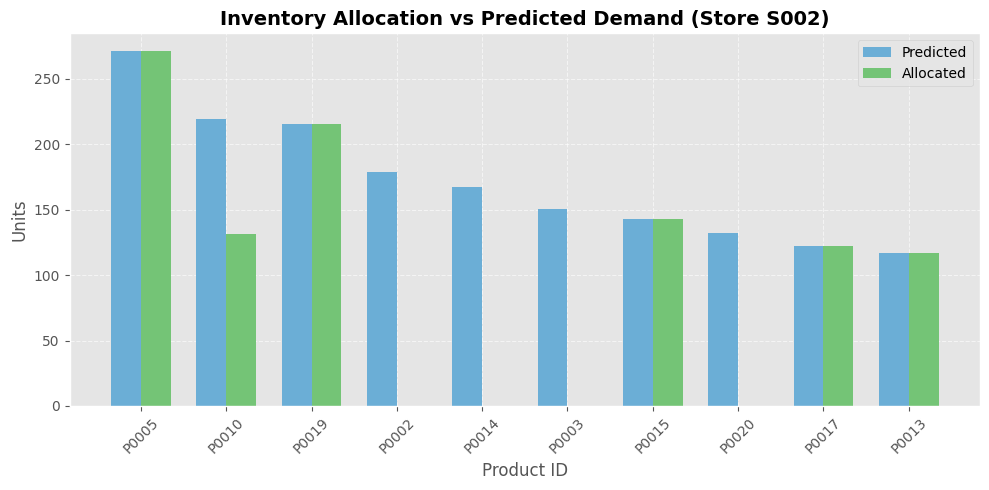

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Data prep
plot_df = df_optimize.set_index('Product ID')[['Predicted Demand', 'Allocated Stock']]
x = np.arange(len(plot_df))  # label locations
width = 0.35

# Optional: use built-in Matplotlib style
plt.style.use('ggplot')  # safe and visually appealing

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Bars
bars1 = ax.bar(x - width/2, plot_df['Predicted Demand'], width, label='Predicted', color='#6baed6')
bars2 = ax.bar(x + width/2, plot_df['Allocated Stock'], width, label='Allocated', color='#74c476')

# Labels & Title
ax.set_title(f"Inventory Allocation vs Predicted Demand (Store {store_id})", fontsize=14, fontweight='bold')
ax.set_xlabel("Product ID")
ax.set_ylabel("Units")
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 2. Lets go with all the stores

In [65]:
from pulp import LpProblem, LpVariable, LpMinimize, lpSum

# Store-level results
all_store_results = []

# Optional: define capacity per store (same or custom)
store_capacity = {
    store: 1000 for store in df['Store ID'].unique()  # same capacity for now
}

In [66]:
for store_id in df['Store ID'].unique():
    df_store = df[df['Store ID'] == store_id].copy()
    latest_date = df_store['Date'].max()
    df_latest = df_store[df_store['Date'] == latest_date].copy()

    # Predict demand
    X_latest = df_latest[features]
    df_latest.loc[:, 'Predicted Demand'] = model_xgb.predict(X_latest)

    # Top 10 products (adjustable)
    df_optimize = df_latest[['Product ID', 'Predicted Demand']].sort_values(
        by='Predicted Demand', ascending=False).head(10).reset_index(drop=True)

    # Set up LP problem
    prob = LpProblem(f"Store_{store_id}_Inventory_Optimization", LpMinimize)
    alloc_vars = {
        row['Product ID']: LpVariable(f"x_{row['Product ID']}", lowBound=0)
        for _, row in df_optimize.iterrows()
    }
    error_vars = {
        p: LpVariable(f"e_{p}", lowBound=0)
        for p in alloc_vars
    }

    # Constraints
    prob += lpSum(alloc_vars[p] for p in alloc_vars) <= store_capacity[store_id]

    for p in alloc_vars:
        pred = df_optimize[df_optimize['Product ID'] == p]['Predicted Demand'].values[0]
        prob += alloc_vars[p] - pred <= error_vars[p]
        prob += pred - alloc_vars[p] <= error_vars[p]

    # Objective
    prob += lpSum(error_vars[p] for p in error_vars)
    prob.solve()

    # Save results
    allocations = {p: alloc_vars[p].varValue for p in alloc_vars}
    df_optimize['Allocated Stock'] = df_optimize['Product ID'].map(allocations)
    df_optimize['Store ID'] = store_id

    all_store_results.append(df_optimize)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/venv1/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/n4/d6h4j3h95x333c3mmcxh697w0000gn/T/797ee11f395944bc873c3efa99678c99-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/n4/d6h4j3h95x333c3mmcxh697w0000gn/T/797ee11f395944bc873c3efa99678c99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26 COLUMNS
At line 87 RHS
At line 109 BOUNDS
At line 110 ENDATA
Problem MODEL has 21 rows, 20 columns and 50 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 21 (0) rows, 20 (0) columns and 50 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 9.6816743e-06 ( 0.00096816743%) - largest zero change 9.5551847e-06
0  Obj 0 Primal inf 1717.1081 (10)
15  Obj 717.12077
Optimal - objective value 717.10809
Optimal objective 717.1080856

In [67]:
df_all_allocations = pd.concat(all_store_results).reset_index(drop=True)

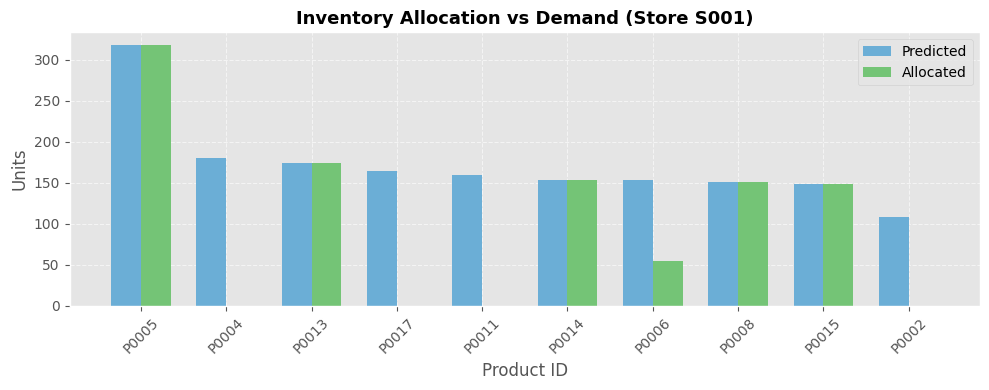

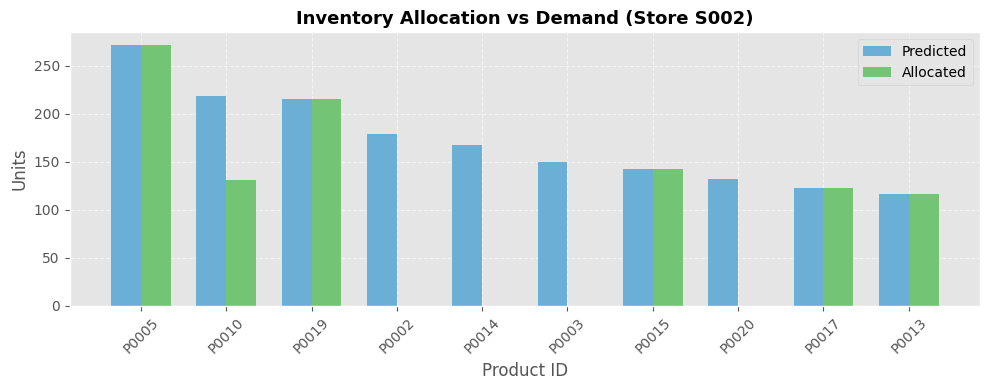

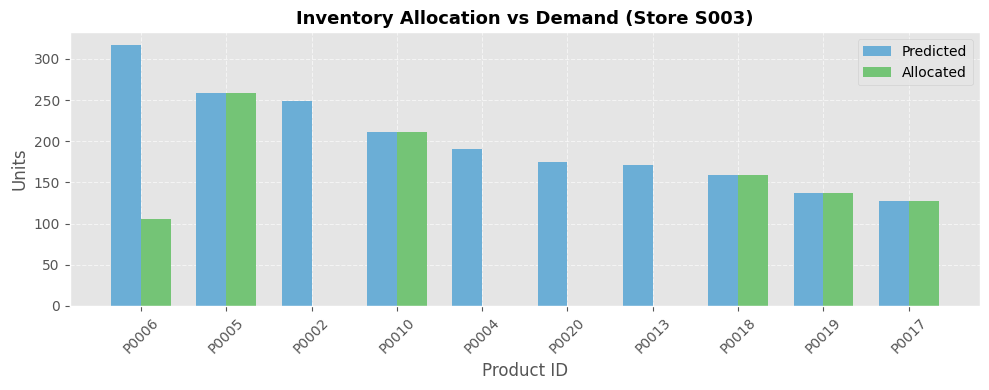

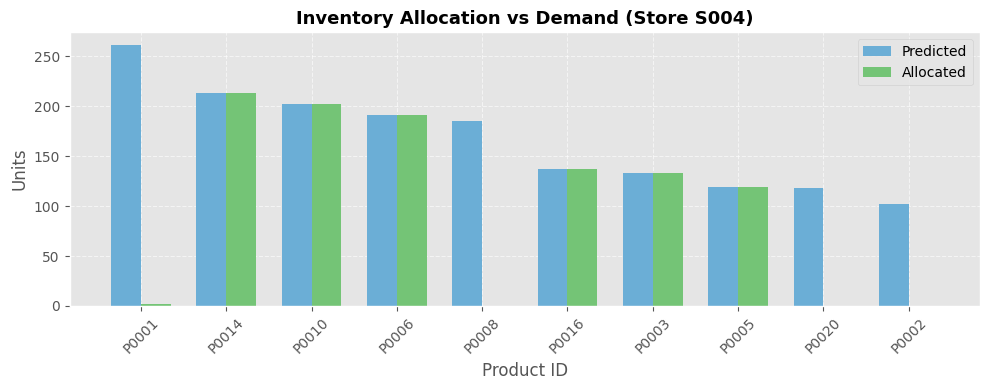

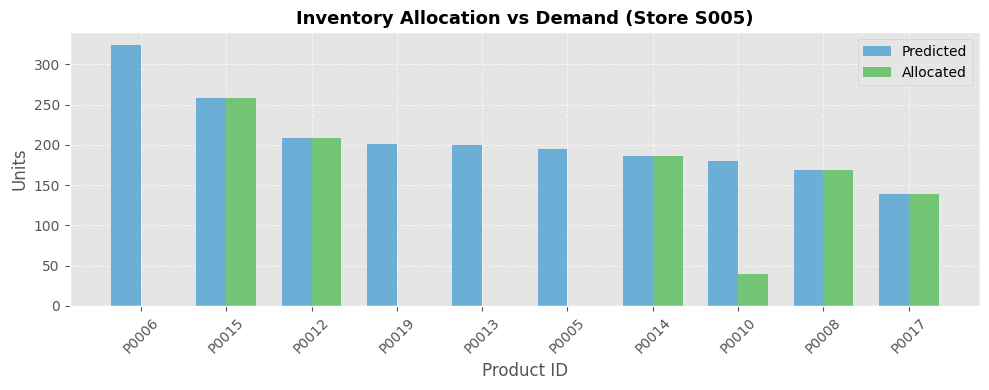

In [68]:
for store_id, group in df_all_allocations.groupby('Store ID'):
    plot_df = group.set_index('Product ID')[['Predicted Demand', 'Allocated Stock']]
    x = np.arange(len(plot_df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(x - width/2, plot_df['Predicted Demand'], width, label='Predicted', color='#6baed6')
    ax.bar(x + width/2, plot_df['Allocated Stock'], width, label='Allocated', color='#74c476')

    ax.set_title(f"Inventory Allocation vs Demand (Store {store_id})", fontsize=13, fontweight='bold')
    ax.set_xlabel("Product ID")
    ax.set_ylabel("Units")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=45)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
